In [1]:
# Load the data and libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def laplace_mech_vec(vec, sensitivity, epsilon):
    return [v + np.random.laplace(loc=0, scale=sensitivity / epsilon) for v in vec]

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(vec, sensitivity, epsilon, delta):
    return [v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)
            for v in vec]

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

def above_threshold(queries, T, epsilon):
    T_hat = T + np.random.laplace(loc=0, scale = 2/epsilon)
    
    for idx, q in enumerate(queries):
        nu_i = np.random.laplace(loc=0, scale = 4/epsilon)
        if q + nu_i >= T_hat:
            return idx
    return random.randint(0,len(queries)-1)

def range_query(df, col, a, b):
    return len(df[(df[col] >= a) & (df[col] < b)])


In [2]:
import requests
from io import StringIO

url = 'https://raw.githubusercontent.com/kierajclarke/Final-Data-Project/main/student_math_clean.csv'
response = requests.get(url)
raw_data = pd.read_csv(StringIO(response.text))


# Preprocessing

First we select columns related to academic metrics and sex and preprocess the data. Since our aim is to analyze the data of highschool students, we want to limit the age range of the students so that outlying ages do not skew accuracy.

In [3]:
# Select columns to go into data
columns = ['age', 'sex', 'grade_1', 'grade_2', 'final_grade']
data = raw_data[columns]


# Convert grades to percentages
# Multiply by 5 to convert from 0-20 to 0-100
data.loc[:, ['grade_1', 'grade_2', 'final_grade']] = raw_data[['grade_1', 'grade_2', 'final_grade']] * 5

# Display the first few rows with grades converted to percentages
print(data.head())

# Separate the data by sex
male_data = data[data['sex'] == 'M']
female_data = data[data['sex'] == 'F']

   age sex  grade_1  grade_2  final_grade
0   18   F       25       30           30
1   17   F       25       25           30
2   15   F       35       40           50
3   15   F       75       70           75
4   16   F       30       50           50


# Average Grades

## Laplace and Gaussian Differential Privacy

#### Actual Means

In [4]:
# Calculate means for each sex
mean_grade_male = male_data['final_grade'].mean()
mean_grade_female = female_data['final_grade'].mean()

print("Mean final grade for Male students:", mean_grade_male)
print("Mean final grade for Female students:", mean_grade_female)


Mean final grade for Male students: 54.57219251336898
Mean final grade for Female students: 49.83173076923077


#### Laplace Mechanism

In [5]:
def laplace_mean_grade(df, epsilon):
    def create_query(b):
        return df.clip(lower=0, upper=b).sum() - df.clip(lower=0, upper=b+1).sum()
    
    bs = list(range(0, 100, 1))

    # Construct the stream of queries
    queries = [create_query(b) for b in bs]
    
    # Run AboveThreshold, using 1/3 of the privacy budget, to find a good upper clipping parameter/sensitivity
    epsilon_svt = epsilon / 3
    final_b = bs[above_threshold(queries, 0, epsilon_svt)]

    # Compute the noisy sum and noisy count, using 1/3 of the privacy budget for each
    epsilon_sum = epsilon / 3
    epsilon_count = epsilon / 3
    
    noisy_sum = laplace_mech(df.clip(lower=0, upper=final_b).sum(), final_b, epsilon_sum)
    noisy_count = laplace_mech(len(df), 1, epsilon_count)
    
    return noisy_sum / noisy_count

# Apply Laplace noise to counts and sums
laplace_mean_grade_male = laplace_mean_grade(male_data['final_grade'], 1.0)
laplace_mean_grade_female = laplace_mean_grade(female_data['final_grade'], 1.0)

print("Laplace mean final grade for Male students:", laplace_mean_grade_male)
print("Laplace mean final grade for Female students:", laplace_mean_grade_female)


Laplace mean final grade for Male students: 53.27673177834193
Laplace mean final grade for Female students: 50.776508352928474


#### Gaussian Mechanism

In [6]:
def gaussian_mean_grade(df, epsilon, delta):
    def create_query(b):
        return df.clip(lower=0, upper=b).sum() - df.clip(lower=0, upper=b+1).sum()
    
    bs = list(range(0, 100, 1))

    # Construct the stream of queries
    queries = [create_query(b) for b in bs]
    
    # Run AboveThreshold, using 1/3 of the privacy budget, to find a good upper clipping parameter/sensitivity
    epsilon_svt = epsilon / 3
    final_b = bs[above_threshold(queries, 0, epsilon_svt)]

    # Compute the noisy sum and noisy count, using 1/3 of the privacy budget for each
    epsilon_sum = epsilon / 3
    epsilon_count = epsilon / 3
    
    noisy_sum = gaussian_mech(df.clip(lower=0, upper=final_b).sum(), final_b, epsilon_sum, delta)
    noisy_count = gaussian_mech(len(df), 1, epsilon_count, delta)
    
    return noisy_sum / noisy_count
    
gaussian_mean_grade_male = gaussian_mean_grade(male_data['final_grade'], 1.0, 1e-5)
gaussian_mean_grade_female = gaussian_mean_grade(female_data['final_grade'], 1.0, 1e-5)

print("Noisy mean grades for Male students:", gaussian_mean_grade_male)
print("Noisy mean grades for Female students:", gaussian_mean_grade_female)

Noisy mean grades for Male students: 48.18729232045374
Noisy mean grades for Female students: 47.13388924769339


## Comparison of Laplace and Gaussian

#### Graphs

In [7]:
# Compute values in their own cell so that we don't have to keep rerunning the thing - takes forever
laplace_mean_grades_male = [laplace_mean_grade(male_data['final_grade'], 1.0) for _ in range(1000)]
print("Laplace Male - Done")
gaussian_mean_grades_male = [gaussian_mean_grade(male_data['final_grade'], 1.0, 1e-5) for _ in range(1000)]
print("Gaussian Male - Done")

laplace_mean_grades_female = [laplace_mean_grade(female_data['final_grade'], 1.0) for _ in range(1000)]
print("Laplace Female - Done")
gaussian_mean_grades_female = [gaussian_mean_grade(female_data['final_grade'], 1.0, 1e-5) for _ in range(1000)]
print("Gaussian Female - Done")

Laplace Male - Done
Gaussian Male - Done
Laplace Female - Done
Gaussian Female - Done


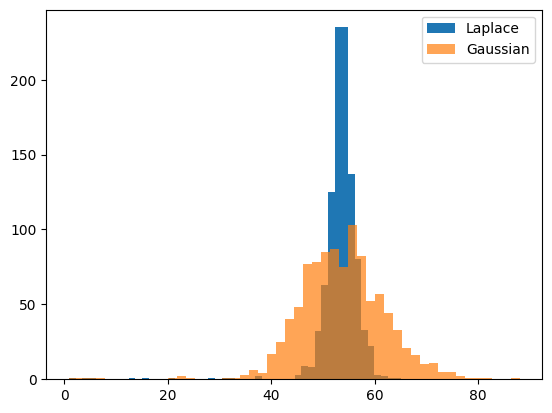

In [8]:
plt.hist(laplace_mean_grades_male, bins=50, label='Laplace')
plt.hist(gaussian_mean_grades_male, alpha=.7, bins=50, label='Gaussian')
plt.legend()

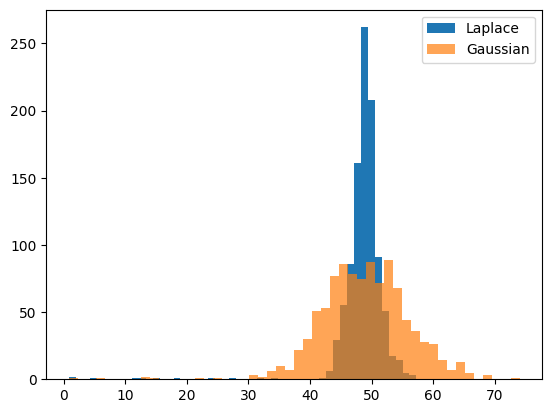

In [9]:
plt.hist(laplace_mean_grades_female, bins=50, label='Laplace')
plt.hist(gaussian_mean_grades_female, alpha=.7, bins=50, label='Gaussian')
plt.legend()

#### Percent Errors

In [10]:
laplace_male_pct_error = np.mean([pct_error(mean_grade_male, x) for x in laplace_mean_grades_male])
gaussian_male_pct_error = np.mean([pct_error(mean_grade_male, x) for x in gaussian_mean_grades_male])

laplace_female_pct_error = np.mean([pct_error(mean_grade_female, x) for x in laplace_mean_grades_female])
gaussian_female_pct_error = np.mean([pct_error(mean_grade_female, x) for x in gaussian_mean_grades_female])

print("Average Percent Error Laplace Male: ", laplace_male_pct_error)
print("Average Percent Error Gaussian Male: ", gaussian_male_pct_error)

print("Average Percent Error Laplace Female: ", laplace_female_pct_error)
print("Average Percent Error Gaussian Female: ", gaussian_female_pct_error)

Average Percent Error Laplace Male:  4.361552392706846
Average Percent Error Gaussian Male:  11.811458634547984
Average Percent Error Laplace Female:  4.277596864509281
Average Percent Error Gaussian Female:  11.194565319660837


# Synthetic Data

## Two-Marginals

In [11]:
def dp_two_marginal(df, col1, col2, epsilon):
    # Empty dataframe to hold everything
    out_df = pd.DataFrame()
    
    # Get crosstab
    ct = pd.crosstab(df[col1], df[col2])
    
    # Apply laplace mechanism to data in crosstab
    dp_ct = ct.map(lambda x: max(laplace_mech(x, 1, epsilon), 0))
    
    # Convert to list of lists
    dp_vals = dp_ct.stack().reset_index().values.tolist()
    
    # Add columns 1 and 2 to dataframe
    col1_data = [a for a,_,_ in dp_vals]
    col2_data = [b for _,b,_ in dp_vals]
    out_df[col1] = col1_data
    out_df[col2] = col2_data
    
    # Calculate probabilities and add to dataframe
    probs = [p for _,_,p in dp_vals]
    probs_norm = probs / np.sum(probs)
    out_df['probability'] = probs_norm
    
    return out_df

In [12]:
def dp_synthetic_data_two_marginal(df, cols, n, epsilon):
    
    # Get marginals
    marg0 = dp_two_marginal(df, cols[0], cols[1], epsilon)
    marg1 = dp_two_marginal(df, cols[1], cols[2], epsilon)
    marg2 = dp_two_marginal(df, cols[2], cols[3], epsilon)
    marg3 = dp_two_marginal(df, cols[3], cols[4], epsilon)
    
    # Sample initial data from marg0
    syn_df = marg0.sample(n, replace=True, weights=marg0['probability'])[[cols[0], cols[1]]]
    
    # Add grade_1 data
    grade_1s = []
    
    for val in syn_df[cols[1]]:
        
        # Get data for relevant Sex
        marg1_filter = marg1.loc[marg1[cols[1]] == val].copy()
        
        # Normalize filtered data
        marg1_filter['probability'] = marg1_filter['probability'] / marg1_filter['probability'].sum()
        
        dp_vals = list(marg1_filter.itertuples(index=False, name=None))
        
        probs = [p for _,_,p in dp_vals]
        vals = [b for _,b,_ in dp_vals]
        
        indices = range(0, len(vals))
        i = np.random.choice(indices, p=probs)
        grade_1s.append(vals[i])
        
    syn_df[cols[2]] = grade_1s
    
    # Add grade_2 data
    grade_2s = []
    
    for val in syn_df[cols[2]]:
        # Get data for relevant Occupation
        marg2_filter = marg2.loc[marg2[cols[2]] == val].copy()
        
        # Normalize filtered data
        marg2_filter['probability'] = marg2_filter['probability'] / marg2_filter['probability'].sum()
        
        dp_vals = list(marg2_filter.itertuples(index=False, name=None))
        
        probs = [p for _,_,p in dp_vals]
        vals = [b for _,b,_ in dp_vals]
        
        indices = range(0, len(vals))
        
        i = np.random.choice(indices, p=probs)
        grade_2s.append(vals[i])
        
    syn_df[cols[3]] = grade_2s
    
    # Add final grade data
    final_grades = []
    
    for val in syn_df[cols[3]]:
        # Get data for relevant Occupation
        marg3_filter = marg3.loc[marg3[cols[3]] == val].copy()
        
        # Normalize filtered data
        marg3_filter['probability'] = marg3_filter['probability'] / marg3_filter['probability'].sum()
        
        dp_vals = list(marg3_filter.itertuples(index=False, name=None))
        
        probs = [p for _,_,p in dp_vals]
        vals = [b for _,b,_ in dp_vals]
        
        indices = range(0, len(vals))
        
        i = np.random.choice(indices, p=probs)
        final_grades.append(vals[i])
        
    syn_df[cols[4]] = final_grades
    
    return syn_df

two_marginal_data = dp_synthetic_data_two_marginal(data, columns, 395, 1.0)
two_marginal_data

,age,sex,grade_1,grade_2,final_grade
3,16,M,70,80.0,55.0
3,16,M,75,75.0,60.0
2,16,F,65,70.0,75.0
7,18,M,40,40.0,55.0
3,16,M,30,45.0,0.0
...,...,...,...,...,...
8,19,F,50,60.0,55.0
7,18,M,95,20.0,95.0
5,17,M,65,60.0,60.0
2,16,F,65,70.0,75.0


## Five-Marginals

In [13]:
def dp_five_marginal(df, col0, col1, col2, col3, col4, epsilon):
    # Empty dataframe to hold everything
    out_df = pd.DataFrame()
    
    # Get crosstab
    ct = pd.crosstab([df[col1], df[col2], df[col3], df[col4]], df[col0])
    
    # Apply laplace mechanism to data in crosstab
    dp_ct = ct.map(lambda x: max(laplace_mech(x, 1, epsilon), 0))
    
    # Convert to list of lists
    dp_vals = dp_ct.stack().reset_index().values.tolist()
    
    # Add columns to dataframe
    col1_data = [a for a,_,_,_,_,_ in dp_vals]
    col2_data = [b for _,b,_,_,_,_ in dp_vals]
    col3_data = [c for _,_,c,_,_,_ in dp_vals]
    col4_data = [d for _,_,_,d,_,_ in dp_vals]
    col0_data = [e for _,_,_,_,e,_ in dp_vals]
    out_df[col0] = col0_data
    out_df[col1] = col1_data
    out_df[col2] = col2_data
    out_df[col3] = col3_data
    out_df[col4] = col4_data
    
    # Calculate probabilities and add to dataframe
    probs = [p for _,_,_,_,_,p in dp_vals]
    probs_norm = probs / np.sum(probs)
    out_df['probability'] = probs_norm
    
    return out_df

In [14]:
def dp_synthetic_data_five_marginal(df, cols, n, epsilon):
    marg = dp_five_marginal(df, *cols, epsilon)
    
    return marg.sample(n, replace=True, weights=marg['probability']).drop('probability', axis=1)

five_marginal_data = dp_synthetic_data_five_marginal(data, columns, 395, 1.0)
five_marginal_data

,age,sex,grade_1,grade_2,final_grade
1157,20,M,30,45,40
936,15,F,75,70,75
257,16,F,40,35,40
1776,15,M,65,75,75
154,17,F,35,35,40
...,...,...,...,...,...
199,22,F,35,40,50
807,22,F,65,65,55
1255,22,M,40,35,40
630,21,F,55,55,60
